# TP Final

Autor: Abraham Rodriguez

Repositorio: https://github.com/AbeRodz/Time-series-II.git

## Proposito

Este proyecto consiste en utilzar datos de yahoo finance para analizar y predecir el stock de AAPL con arquitecturas de deep learning.

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

import torch 
from torch import nn, optim, Tensor
from torch.nn import functional as F
from torch.mps import is_available
from torch.cuda import is_available as cuda_is_available
from torch.utils.data import DataLoader,  Dataset
from trainer import Trainer

from typing import Tuple, List, Optional,Type

In [2]:
device = torch.device("mps") if is_available() else torch.device("cpu") if cuda_is_available() else torch.device("cpu")
print(f"Using device: {device}")

Using device: mps


In [71]:
def count_parameters(model: nn.Module) -> int:
    """
    Count the number of trainable parameters in a PyTorch model.

    Args:
        model (nn.Module): The PyTorch model.

    Returns:
        int: The total number of trainable parameters.
    """
    return sum(p.numel() for p in model.parameters() if p.requires_grad) / 1_000_000

In [4]:
ticker = 'AAPL'
data = yf.download(ticker, start="2015-01-01", end="2025-08-30")
data_close = data[['Close']]

/var/folders/bf/p7_3d4ln30l_vsv0f_41b4sw0000gn/T/ipykernel_2747/1999013318.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-08-30")
[*********************100%***********************]  1 of 1 completed


In [5]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data_close.values)  # numpy array

In [6]:
# Usar 80% de los datos para entrenamiento y 20% para prueba
train_size = int(len(data_close) * 0.8)
train_data, test_data = data_close[:train_size], data_close[train_size:]
print(f"Tamaño del conjunto de entrenamiento: {len(train_data)}")
print(f"Tamaño del conjunto de prueba: {len(test_data)}")

time_step = 60

Tamaño del conjunto de entrenamiento: 2144
Tamaño del conjunto de prueba: 537


In [7]:


class TimeSeriesDataset(Dataset):
    def __init__(self, data, dates, window_size=60):
        """
        data: scaled numpy array, shape (n_samples, 1)
        dates: datetime index aligned with 'data'
        """
        self.data = torch.tensor(data, dtype=torch.float32)
        self.dates = np.array(dates)
        self.window_size = window_size

    def __len__(self):
        return len(self.data) - self.window_size

    def __getitem__(self, idx):
        x = self.data[idx : idx+self.window_size]
        y = self.data[idx+self.window_size]
        date = self.dates[idx+self.window_size].item()  # convert numpy.datetime64 -> Python datetime
        return x, y, date


In [8]:
data_close.index.values

array(['2015-01-02T00:00:00.000000000', '2015-01-05T00:00:00.000000000',
       '2015-01-06T00:00:00.000000000', ...,
       '2025-08-27T00:00:00.000000000', '2025-08-28T00:00:00.000000000',
       '2025-08-29T00:00:00.000000000'],
      shape=(2681,), dtype='datetime64[ns]')

In [19]:
window_size = 60
dataset = TimeSeriesDataset(scaled_data,
                            data_close.index.values,
                            window_size=window_size)

def collate_fn(batch):
    X = torch.stack([item[0] for item in batch])
    y = torch.stack([item[1] for item in batch])
    dates = [item[2] for item in batch]  # keep as list
    return X, y, dates

batch_size = 32
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)

# sanity check
for X_batch, y_batch, date_batch in dataloader:
    print("X shape:", X_batch.shape)
    print("y shape:", y_batch.shape)
    print("dates:", date_batch[:5])  # list of datetime.datetime objects
    break


X shape: torch.Size([32, 60, 1])
y shape: torch.Size([32, 1])
dates: [1742428800000000000, 1563321600000000000, 1536105600000000000, 1603065600000000000, 1611878400000000000]


In [20]:
split = int(len(dataset) * 0.8)
train_dataset = torch.utils.data.Subset(dataset, range(split))
test_dataset = torch.utils.data.Subset(dataset, range(split, len(dataset)))
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [21]:
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, num_layers=2, output_size=1):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.dropout(out)
        out = self.fc(out[:, -1, :])
        return out

In [22]:
model = LSTMModel().to(device)
m = model.compile()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
trainer = Trainer(
    model,
    train_data_loader=train_loader,
    test_data_loader=test_loader,
    loss_fn=criterion,
    gradient_accumulation_steps=8,
    optimizer=optimizer,
    scheduler= torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5),
    device=device.type,
)

In [139]:
torch.cuda.empty_cache()
print("Número de parámetros: {:.5f} millones".format(count_parameters(model)))

Número de parámetros: 0.03105 millones


In [23]:
for epoch in range(20):
    print(f"Epoch {epoch+1}/10")
    trainer.train_one_epoch_time_series()

Epoch 1/10


loss 0.07358: 100%|██████████| 66/66 [00:00<00:00, 192.39it/s]


Epoch 2/10


loss 0.04708: 100%|██████████| 66/66 [00:00<00:00, 203.36it/s]


Epoch 3/10


loss 0.04892: 100%|██████████| 66/66 [00:00<00:00, 207.17it/s]


Epoch 4/10


loss 0.04368: 100%|██████████| 66/66 [00:00<00:00, 230.51it/s]


Epoch 5/10


loss 0.03368: 100%|██████████| 66/66 [00:00<00:00, 237.19it/s]


Epoch 6/10


loss 0.01228: 100%|██████████| 66/66 [00:00<00:00, 194.91it/s]


Epoch 7/10


loss 0.00720: 100%|██████████| 66/66 [00:00<00:00, 234.33it/s]


Epoch 8/10


loss 0.00299: 100%|██████████| 66/66 [00:00<00:00, 239.73it/s]


Epoch 9/10


loss 0.00256: 100%|██████████| 66/66 [00:00<00:00, 238.52it/s]


Epoch 10/10


loss 0.00257: 100%|██████████| 66/66 [00:00<00:00, 239.96it/s]


Epoch 11/10


loss 0.00183: 100%|██████████| 66/66 [00:00<00:00, 238.30it/s]


Epoch 12/10


loss 0.00170: 100%|██████████| 66/66 [00:00<00:00, 234.49it/s]


Epoch 13/10


loss 0.00131: 100%|██████████| 66/66 [00:00<00:00, 228.95it/s]


Epoch 14/10


loss 0.00183: 100%|██████████| 66/66 [00:00<00:00, 221.82it/s]


Epoch 15/10


loss 0.00122: 100%|██████████| 66/66 [00:00<00:00, 236.11it/s]


Epoch 16/10


loss 0.00134: 100%|██████████| 66/66 [00:00<00:00, 236.32it/s]


Epoch 17/10


loss 0.00119: 100%|██████████| 66/66 [00:00<00:00, 236.74it/s]


Epoch 18/10


loss 0.00126: 100%|██████████| 66/66 [00:00<00:00, 234.90it/s]


Epoch 19/10


loss 0.00113: 100%|██████████| 66/66 [00:00<00:00, 216.10it/s]


Epoch 20/10


loss 0.00086: 100%|██████████| 66/66 [00:00<00:00, 198.73it/s]


In [40]:
def evaluate_time_series(model, data_loader, device, scaler=None):
    """
    Evaluate a trained time-series model.
    Returns y_true, y_pred, metrics, and dates.
    """
    model.eval()
    y_true_list = []
    y_pred_list = []
    dates_list = []

    with torch.no_grad():
        for X_batch, y_batch, date_batch in data_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            output = model(X_batch)

            y_true_list.append(y_batch.cpu())
            y_pred_list.append(output.cpu())
            dates_list.extend(date_batch)  # collect dates

    # Convert to numpy
    y_true = torch.cat(y_true_list, dim=0).numpy()
    y_pred = torch.cat(y_pred_list, dim=0).numpy()
    dates = np.array(dates_list)

    # Inverse transform if scaler provided
    if scaler is not None:
        y_true = scaler.inverse_transform(y_true)
        y_pred = scaler.inverse_transform(y_pred)

    # Compute metrics
    mse = np.mean((y_true - y_pred)**2)
    rmse = np.sqrt(mse)
    mae = np.mean(np.abs(y_true - y_pred))
    mape = np.mean(np.abs((y_true - y_pred)/y_true)) * 100
    metrics = {'MSE': mse, 'RMSE': rmse, 'MAE': mae, 'MAPE': mape}

    return y_true, y_pred, metrics, dates


In [50]:
y_true, y_pred, metrics, dates = evaluate_time_series(
    model=model,
    data_loader=test_loader,
    device=device,
    scaler=scaler  
)

print(metrics)


{'MSE': np.float32(340.17963), 'RMSE': np.float32(18.443958), 'MAE': np.float32(15.201602), 'MAPE': np.float32(7.0010843)}


In [61]:
pd.DataFrame({"truth":y_true.flatten(), "pred":y_pred.flatten()})

,truth,pred
0,193.481354,181.904709
1,194.093933,182.124649
2,193.264008,182.391907
3,190.270340,182.627319
4,188.877228,182.695938
...,...,...
520,226.940002,203.392471
521,229.087921,203.477707
522,230.266785,203.626892
523,232.334778,203.837128


In [51]:
def plot_results(dates, y_true, y_pred):
    import matplotlib.pyplot as plt
    import matplotlib.dates as mdates
    import pandas as pd

    # ensure dates are datetime objects
    dates = pd.to_datetime(dates)

    plt.figure(figsize=(14,5))
    plt.plot(dates, y_true, label='Actual')
    plt.plot(dates, y_pred, label='Predicted')
    plt.title('Time Series Prediction')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()

    # improve x-axis formatting
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


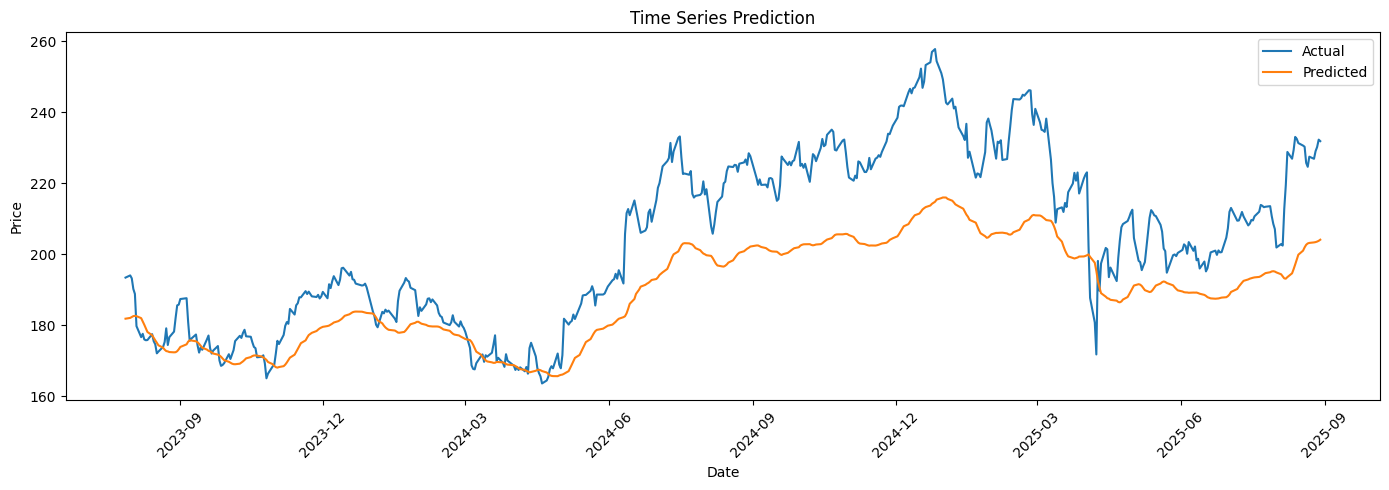

In [52]:
plot_results(dates, y_true, y_pred)

# Transfomer Decoder o GPT

Basado en investigaciones de transformer decoders y arquitecturas GPT aplicadas en tareas de series de tiempo.

- [Lag-Lllama](https://arxiv.org/pdf/2310.08278)
- [TimesFM](https://arxiv.org/pdf/2310.10688)
- [MarketGPT](https://arxiv.org/pdf/2411.16585)
- [Toto](https://arxiv.org/pdf/2407.07874)

La implementacion en este notebook consiste en un GPT ligero.

In [27]:
from dataclasses import dataclass
@dataclass
class GPTConfig:
    """
    Base class for GPT models.
    """
    block_size: int = window_size
    batch_size: int = 8
    n_embd: int = 64
    n_head: int = 4
    n_layer: int = 2
    dropout: float = 0.1
    seq_len: int = window_size
    bias: bool = True
    ff_class: Optional[Type[nn.Module]] = None

config = GPTConfig()
print(config.__dict__)

{'block_size': 60, 'batch_size': 8, 'n_embd': 64, 'n_head': 4, 'n_layer': 2, 'dropout': 0.1, 'seq_len': 60, 'bias': True, 'ff_class': None}


In [28]:
class AttentionHead(nn.Module):
    """
    Scaled Dot-Product Attention Head for Multi-Head Attention.
    """
    def __init__(self, args: GPTConfig) -> None:
        super().__init__()
        assert args.n_embd % args.n_head == 0, "n_embd must be divisible by n_head"
        self.head_dim = args.n_embd // args.n_head

        # Combined QKV projection
        self.key_query_value = nn.Linear(args.n_embd, 3 * self.head_dim, bias=args.bias)

        self.dropout = nn.Dropout(args.dropout)
        self.block_size = args.block_size
        self.register_buffer('tril', torch.tril(torch.ones(args.block_size, args.block_size)))

    def forward(self, x: torch.Tensor, kv_cache: Optional[torch.Tensor] = None, return_weights=False):
        B, T, C = x.shape
        key_query_value = self.key_query_value(x)  # (B, T, 3 * head_dim)
        k, q, v = torch.chunk(key_query_value, 3, dim=-1)  # (B, T, head_dim) each

        if kv_cache is not None:
            key_cache, value_cache = kv_cache.unbind(dim=0)  # (B, T', head_dim)
            k = torch.cat((key_cache, k), dim=1)
            v = torch.cat((value_cache, v), dim=1)

        # Scaled dot-product attention
        wei = q @ k.transpose(-2, -1) * (self.head_dim ** -0.5)  # (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf'))
        wei = F.softmax(wei, dim=-1)
        wei = self.dropout(wei)

        out = wei @ v  # (B, T, head_dim)

        if return_weights:
            return out, wei

        if kv_cache is not None:
            return out, torch.stack((k, v))

        return out, None

In [29]:
class MultiHeadAttention(nn.Module):
    def __init__(self, args: GPTConfig):
        super().__init__()
        assert args.n_embd % args.n_head == 0, "n_embd must be divisible by n_head"
        self.n_heads = args.n_head
        self.head_dim = args.n_embd // args.n_head

        self.heads = nn.ModuleList([
            AttentionHead(args) for _ in range(self.n_heads)
        ])

        self.proj = nn.Linear(args.n_embd, args.n_embd, bias=args.bias)
        self.dropout = nn.Dropout(args.dropout)

    def forward(self, x, kv_cache=None, return_weights=False):
        all_outputs = []
        all_weights = []
        new_kv_cache = [] if kv_cache is not None else None

        for i, head in enumerate(self.heads):
            head_cache = kv_cache[i] if kv_cache is not None else None
            out, weights_or_kv = head(x, kv_cache=head_cache, return_weights=return_weights)
            all_outputs.append(out)
            if return_weights:
                all_weights.append(weights_or_kv)
            if kv_cache is not None:
                new_kv_cache.append(weights_or_kv)  # weights_or_kv is new kv_cache here

        concat = torch.cat(all_outputs, dim=-1)  # concat along embedding dim
        out = self.dropout(self.proj(concat))

        if return_weights:
            return out, torch.stack(all_weights)
        if kv_cache is not None:
            return out, new_kv_cache
        return out

In [30]:
class FeedForward(nn.Module):
    def __init__(self, config: GPTConfig):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(config.n_embd, 4 * config.n_embd),
            nn.ReLU(),
            nn.Linear(4 * config.n_embd, config.n_embd),
            nn.Dropout(config.dropout),
        )

    def forward(self, x):
        return self.net(x)

class Block(nn.Module):
    def __init__(self, config: GPTConfig):
        super().__init__()
        self.ln1 = nn.LayerNorm(config.n_embd)
        self.ln2 = nn.LayerNorm(config.n_embd)
        self.attn = MultiHeadAttention(config)

        ff_class = config.ff_class if config.ff_class is not None else FeedForward
        self.ff = ff_class(config)

    def forward(self, x, kv_cache=None, return_weights=False):
        attn_out = self.attn(self.ln1(x), kv_cache=kv_cache, return_weights=return_weights)
        if return_weights:
            attn_out, weights = attn_out
        else:
            weights = None

        if isinstance(attn_out, tuple):
            attn_out, updated_kv = attn_out
        else:
            updated_kv = None

        x = x + attn_out
        x = x + self.ff(self.ln2(x))

        if return_weights:
            return x, updated_kv, weights
        else:
            return x  


In [81]:
class TimeSeriesGPT(nn.Module):
    def __init__(self, block, config: GPTConfig, feature_size=1 ):
        super().__init__()
        self.seq_len = config.seq_len
        self.feature_proj = nn.Linear(feature_size, config.n_embd)
        self.pos_emb = nn.Parameter(torch.zeros(1, config.seq_len, config.n_embd))
        self.blocks = nn.Sequential(*[block(config) for _ in range(config.n_layer)])
        self.ln_f = nn.LayerNorm(config.n_embd)
        self.head = nn.Linear(config.n_embd, 1)

    def forward(self, x):
        x = self.feature_proj(x) + self.pos_emb[:, :x.size(1), :]
        x = self.blocks(x)
        x = self.ln_f(x)
        return self.head(x[:, -1, :])

In [158]:
config.n_layer = 2
config.batch_size = batch_size
config.n_embd = 64
config.n_head = 4
config.bias = False
config.dropout = 0.2

In [159]:
gpt = TimeSeriesGPT(Block, config=config).to(device)

In [160]:
torch.cuda.empty_cache()
print("Número de parámetros: {:.5f} millones".format(count_parameters(gpt)))

Número de parámetros: 0.10362 millones


In [161]:
config

GPTConfig(block_size=60, batch_size=32, n_embd=64, n_head=4, n_layer=2, dropout=0.2, seq_len=60, bias=False, ff_class=None)

In [162]:
assert config.n_embd % config.n_head == 0

In [163]:
criterion = nn.MSELoss()
optimizer = optim.AdamW(gpt.parameters(), lr=1e-3)
gpt_trainer = Trainer(
    gpt,
    train_data_loader=train_loader,
    test_data_loader=test_loader,
    loss_fn=criterion,
    gradient_accumulation_steps=8,
    optimizer=optimizer,
    scheduler= torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5),
    device=device.type,
)

In [164]:
for epoch in range(20):  
    avg_train_loss = gpt_trainer.train_one_epoch_time_series()
    print(f"Epoch {epoch+1} training loss: {avg_train_loss:.4f}")


loss 0.09370: 100%|██████████| 66/66 [00:00<00:00, 114.05it/s]


Epoch 1 training loss: 0.0319


loss 0.03415: 100%|██████████| 66/66 [00:00<00:00, 118.16it/s]


Epoch 2 training loss: 0.0219


loss 0.00831: 100%|██████████| 66/66 [00:00<00:00, 130.05it/s]


Epoch 3 training loss: 0.0076


loss 0.00700: 100%|██████████| 66/66 [00:00<00:00, 130.01it/s]


Epoch 4 training loss: 0.0058


loss 0.00400: 100%|██████████| 66/66 [00:00<00:00, 118.25it/s]


Epoch 5 training loss: 0.0050


loss 0.00315: 100%|██████████| 66/66 [00:00<00:00, 129.70it/s]


Epoch 6 training loss: 0.0029


loss 0.00257: 100%|██████████| 66/66 [00:00<00:00, 130.36it/s]


Epoch 7 training loss: 0.0024


loss 0.00184: 100%|██████████| 66/66 [00:00<00:00, 131.06it/s]


Epoch 8 training loss: 0.0017


loss 0.00167: 100%|██████████| 66/66 [00:00<00:00, 122.71it/s]


Epoch 9 training loss: 0.0016


loss 0.00139: 100%|██████████| 66/66 [00:00<00:00, 116.56it/s]


Epoch 10 training loss: 0.0012


loss 0.00121: 100%|██████████| 66/66 [00:00<00:00, 118.84it/s]


Epoch 11 training loss: 0.0013


loss 0.00114: 100%|██████████| 66/66 [00:00<00:00, 129.42it/s]


Epoch 12 training loss: 0.0012


loss 0.00115: 100%|██████████| 66/66 [00:00<00:00, 124.20it/s]


Epoch 13 training loss: 0.0012


loss 0.00122: 100%|██████████| 66/66 [00:00<00:00, 129.07it/s]


Epoch 14 training loss: 0.0011


loss 0.00106: 100%|██████████| 66/66 [00:00<00:00, 128.67it/s]


Epoch 15 training loss: 0.0012


loss 0.00088: 100%|██████████| 66/66 [00:00<00:00, 129.67it/s]


Epoch 16 training loss: 0.0009


loss 0.00091: 100%|██████████| 66/66 [00:00<00:00, 130.20it/s]


Epoch 17 training loss: 0.0008


loss 0.00066: 100%|██████████| 66/66 [00:00<00:00, 130.22it/s]


Epoch 18 training loss: 0.0006


loss 0.00080: 100%|██████████| 66/66 [00:00<00:00, 124.14it/s]


Epoch 19 training loss: 0.0007


loss 0.00072: 100%|██████████| 66/66 [00:00<00:00, 130.11it/s]


Epoch 20 training loss: 0.0008


In [165]:
y_true, y_pred, metrics, dates = evaluate_time_series(
    model=gpt,
    data_loader=test_loader,
    device=device,
    scaler=scaler  
)

print(metrics)


{'MSE': np.float32(53.45299), 'RMSE': np.float32(7.3111553), 'MAE': np.float32(5.821185), 'MAPE': np.float32(2.743569)}


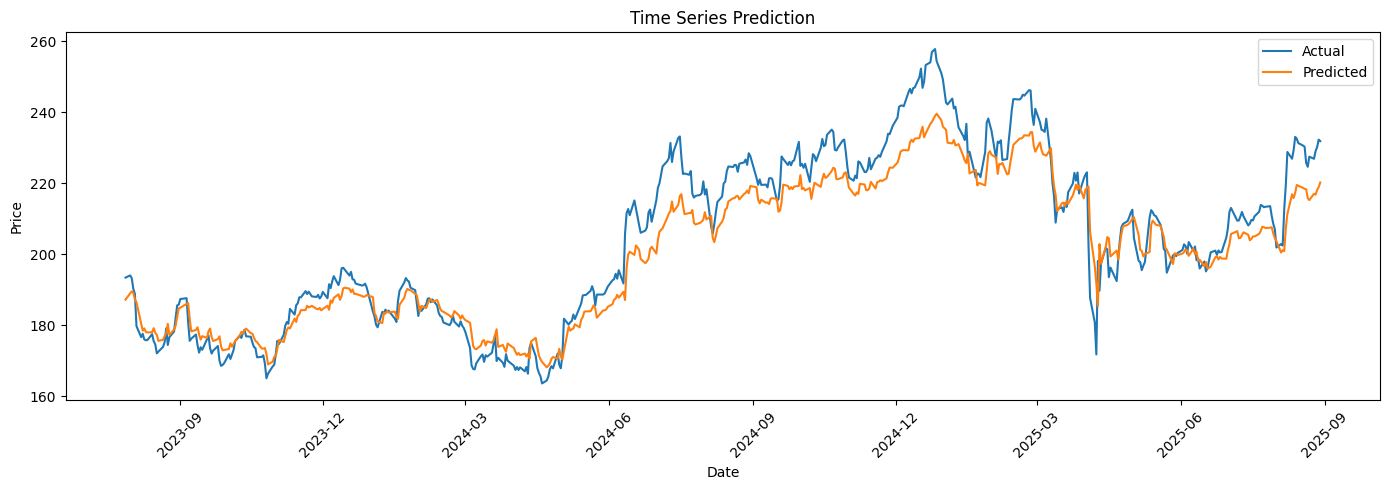

In [166]:
plot_results(dates, y_true, y_pred)

In [167]:
pd.DataFrame({"truth":y_true.flatten(), "pred":y_pred.flatten()})

,truth,pred
0,193.481354,187.273651
1,194.093933,189.068161
2,193.264008,189.592651
3,190.270340,189.190781
4,188.877228,187.324631
...,...,...
520,226.940002,217.079422
521,229.087921,216.836060
522,230.266785,218.189957
523,232.334778,218.979675
